# Neuropixel Spiking and LFP analysis

- [Original Article](https://www.nature.com/articles/s41586-019-1787-x)
- [Neuromatch Notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=J4a1U2AnrDb_)
- [Dataset](https://uni-bonn.sciebo.de/s/Z66tPbIFGGSA3FD)

## Import

In [1]:
import numpy as np
import scipy.signal as sig
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
import os
import scipy.stats as stats
from specparam import SpectralModel
from specparam import SpectralGroupModel
import scipy
from fooof import FOOOF
from fooof import FOOOFGroup

## Load data

In [2]:
# create path for sourcedata steinmetz using pathlib
source_path = Path(os.getcwd()).parent / "sourcedata"
data_path = os.path.join(source_path, "steinmetz_2016-12-14_Cori.nc")
data = nc.Dataset(data_path)

## Extract LFP

In [3]:
brain_area = "MOs"
brain_area_lfp_idx = np.where(data.variables["brain_area_lfp"][:] == brain_area)[0][0]
area_lfp = data.variables["lfp"][brain_area_lfp_idx].data

## Extract spiking

In [4]:
brain_area = "MOs"
brain_area_spike_idx = np.where(data.variables["brain_area"][:] == brain_area)[0]
brain_area_spike_idx
area_spiking = data.variables["spike_rate"][brain_area_spike_idx].data

spiking_activity = np.mean(area_spiking, axis=0)

In [5]:
assert area_lfp.shape == spiking_activity.shape, "Shapes don't match"

## Correlate mean trial PSD with trial spiking activity

In [6]:
sample_rate = 100
freqs, pwr = sig.welch(area_lfp, fs=sample_rate, nperseg=sample_rate // 2)
# freqs, pwr = sig.welch(area_lfp, fs=1000)

mean_psd = np.mean(pwr, axis=1)
mean_psd.shape

mean_spiking_activity = np.sum(spiking_activity, axis=1)
mean_spiking_activity.shape

(364,)

In [7]:
rho, pval = stats.spearmanr(mean_psd, mean_spiking_activity)

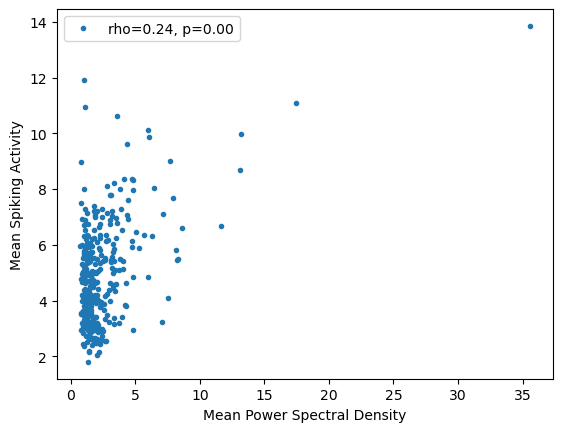

In [8]:
plt.plot(mean_psd, mean_spiking_activity, ".", label=f"rho={rho:.2f}, p={pval:.2f}")
plt.xlabel("Mean Power Spectral Density")
plt.ylabel("Mean Spiking Activity")
plt.legend()

## Tune FOOOF Parameters

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.9130, 0.8962                                          
                                                                                                  
                                       1 peaks were found:                                        
          

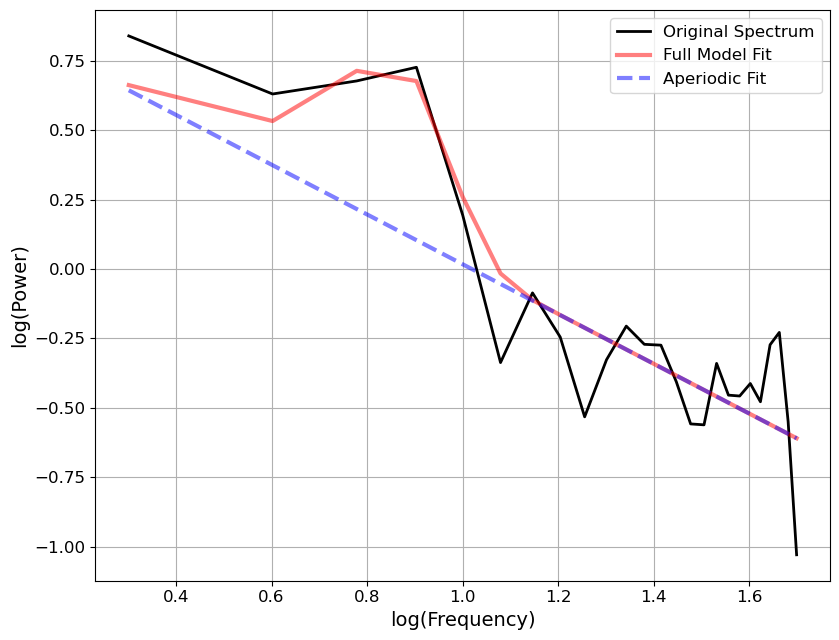

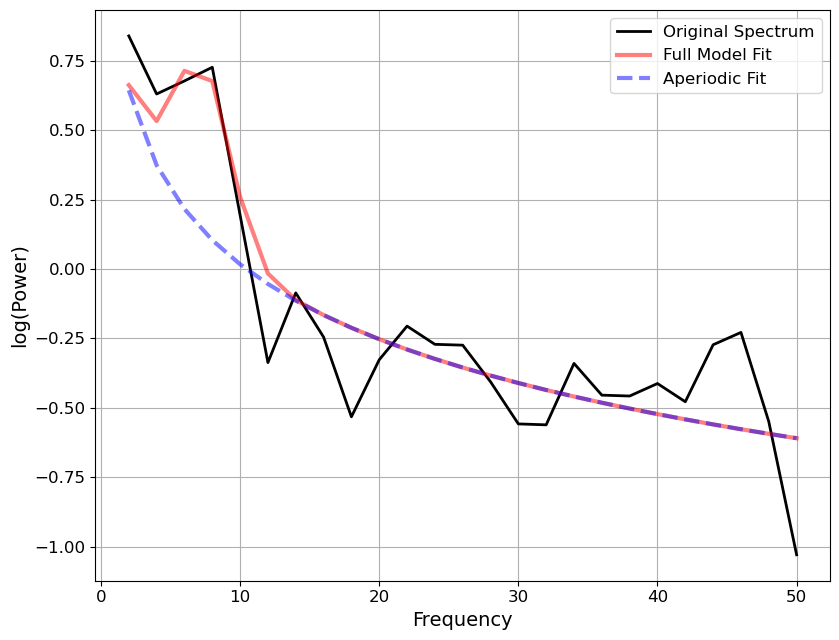

In [9]:
fooof_params = {"max_n_peaks": 1, "peak_width_limits": (4, 8), "verbose": True}
fit_range = [1, 50]

fm = SpectralModel(**fooof_params)
fm.fit(freqs, pwr[0], freq_range=fit_range)
fm.report(plt_log=True)
fm.report(plt_log=False)

## Check exemplary FOOOF fits

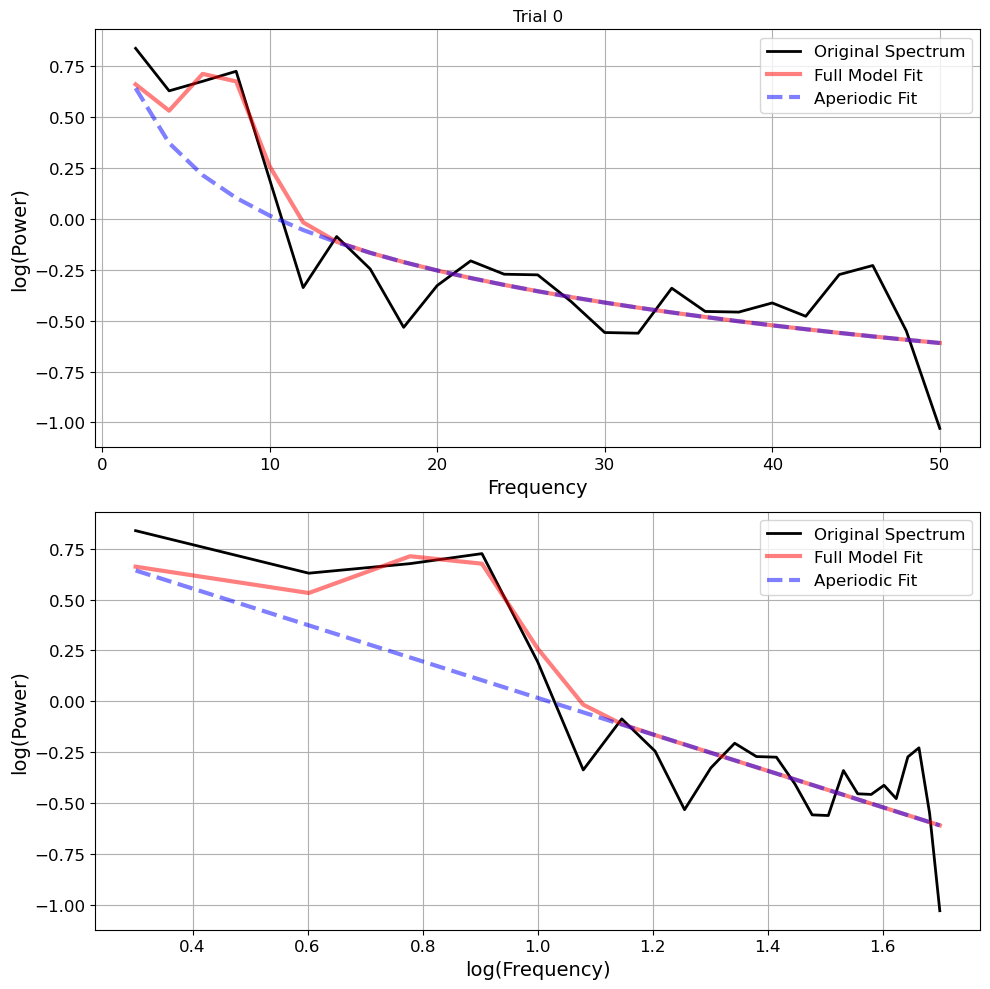

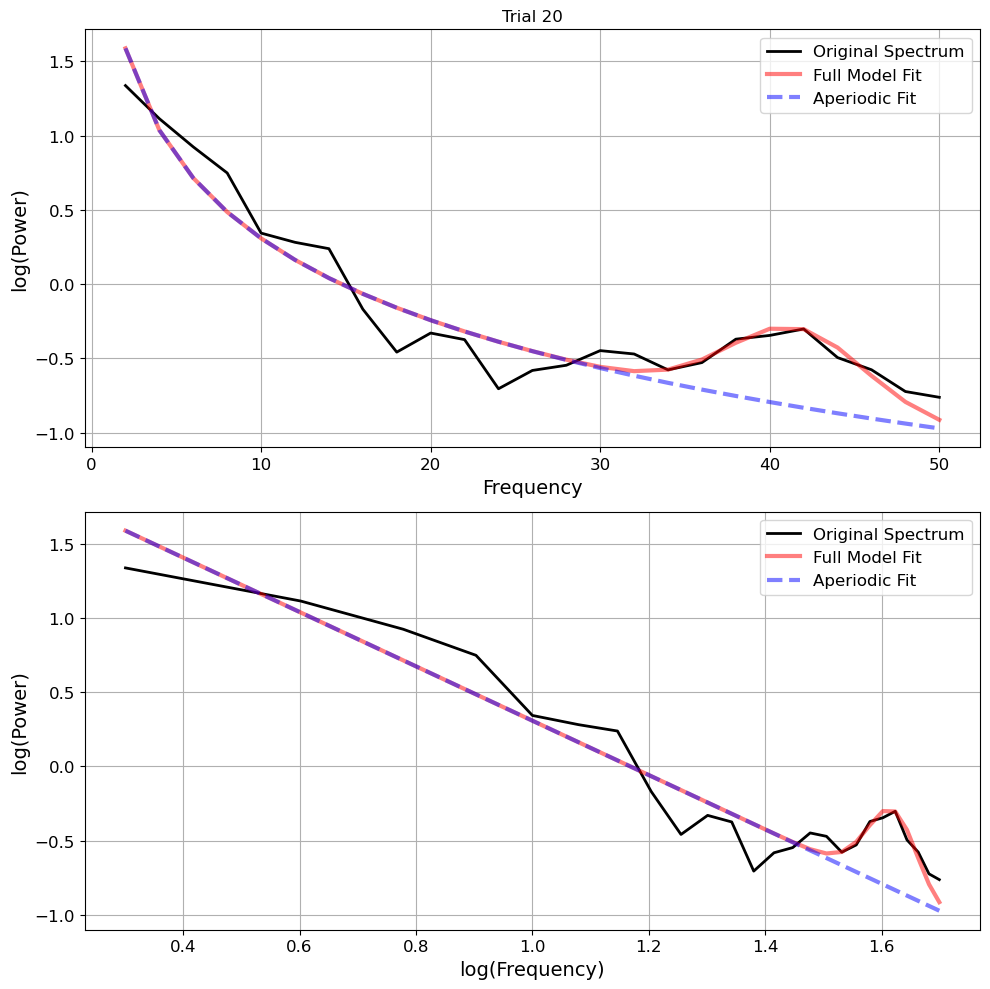

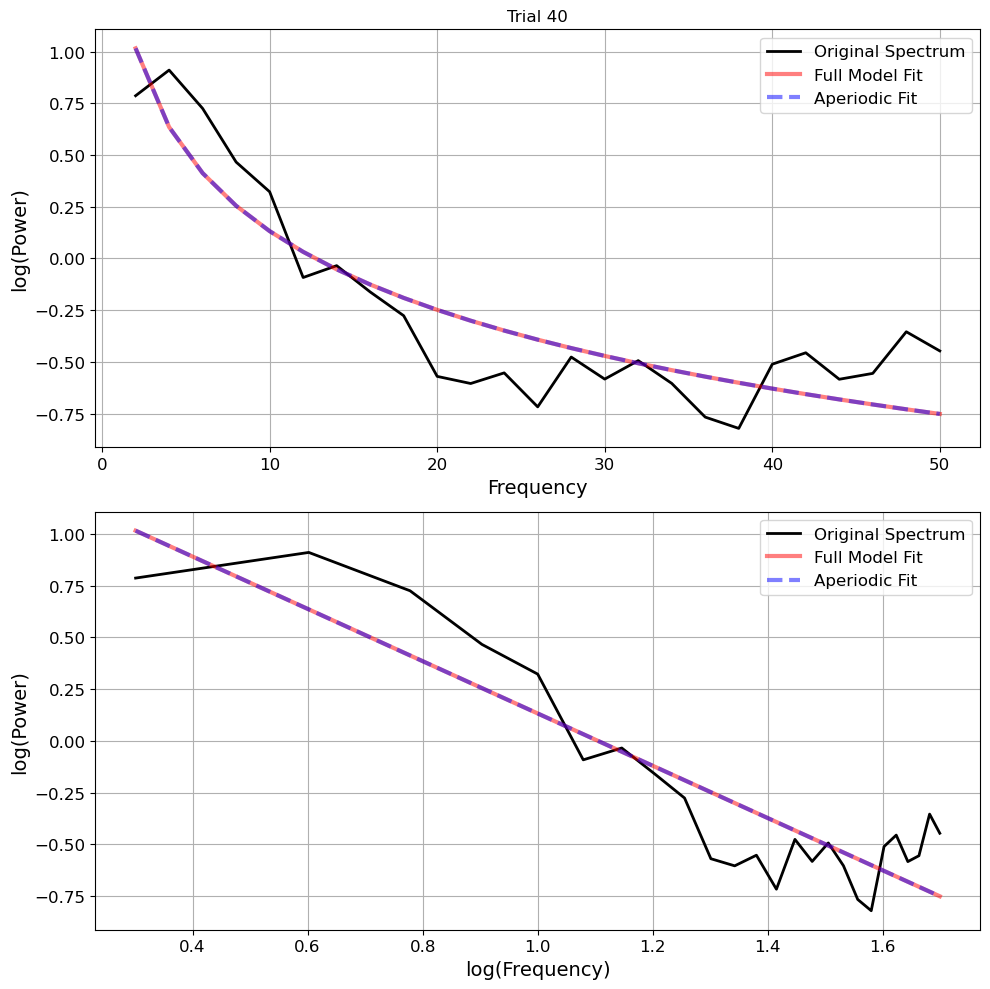

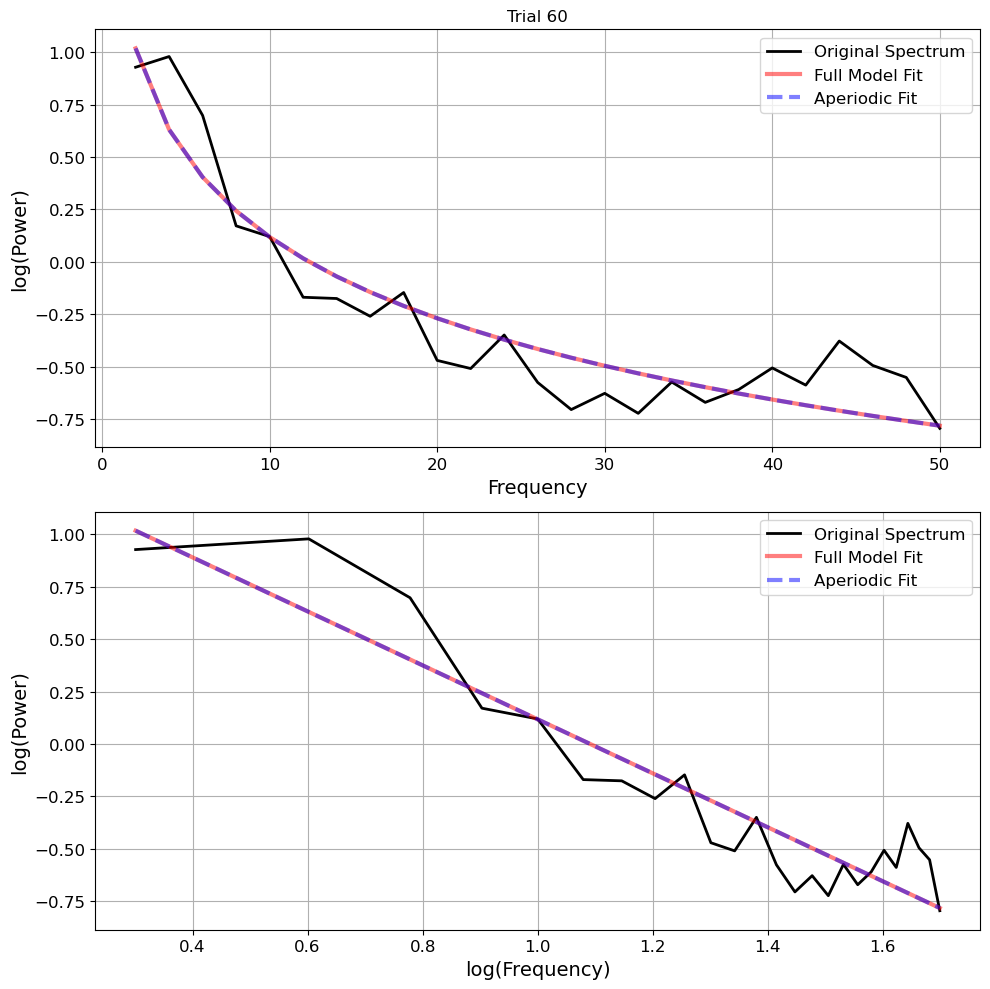

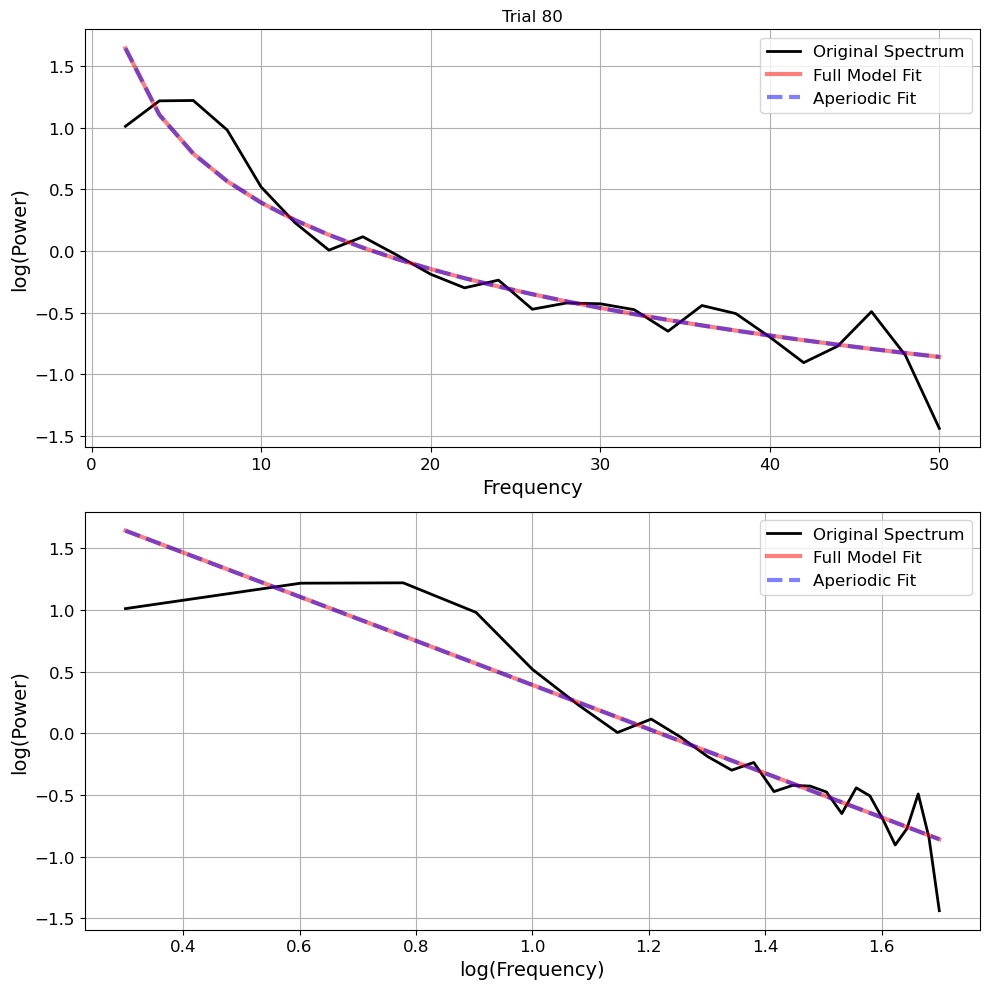

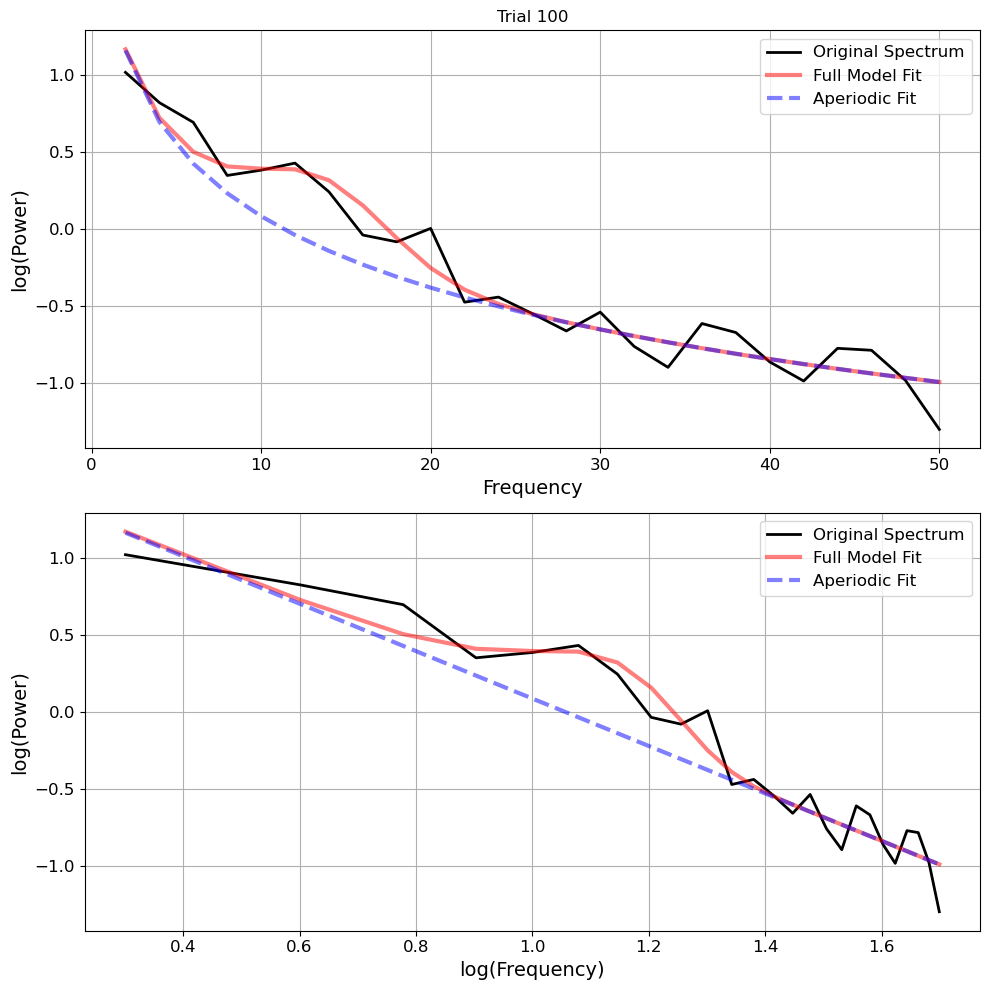

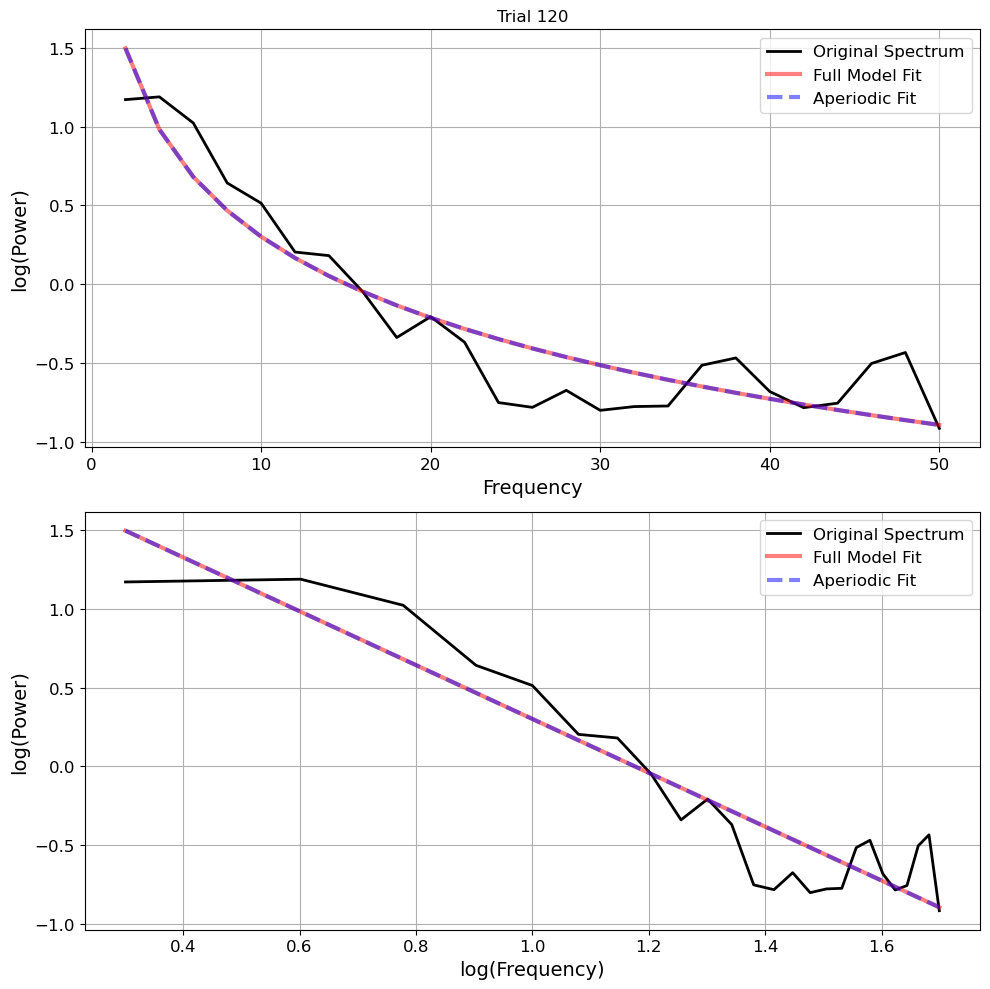

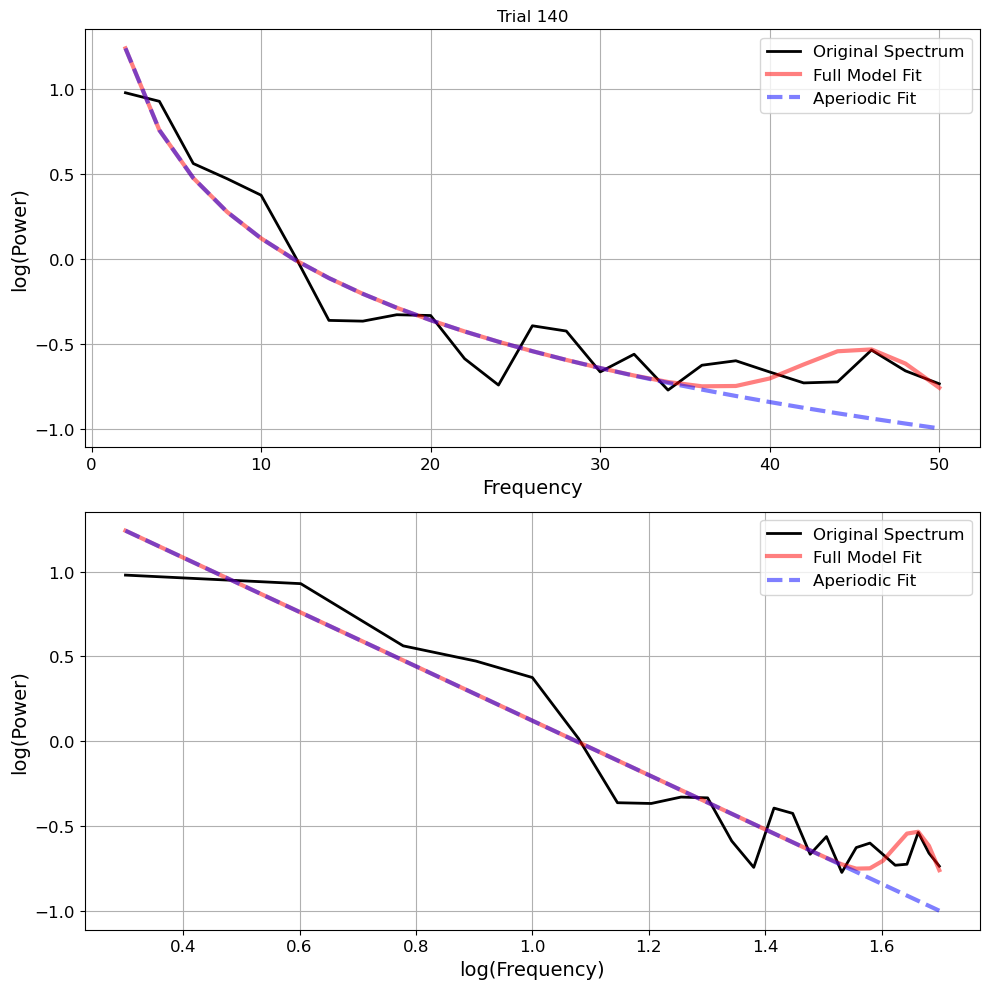

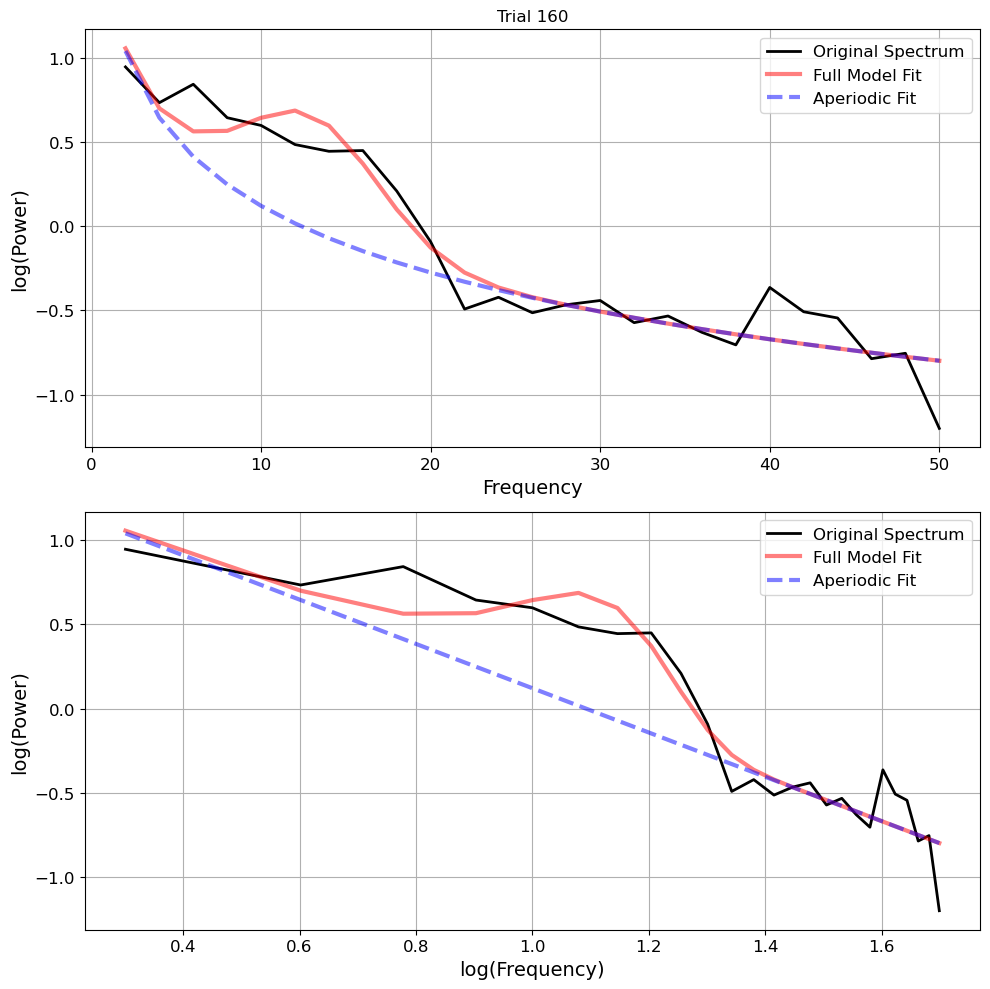

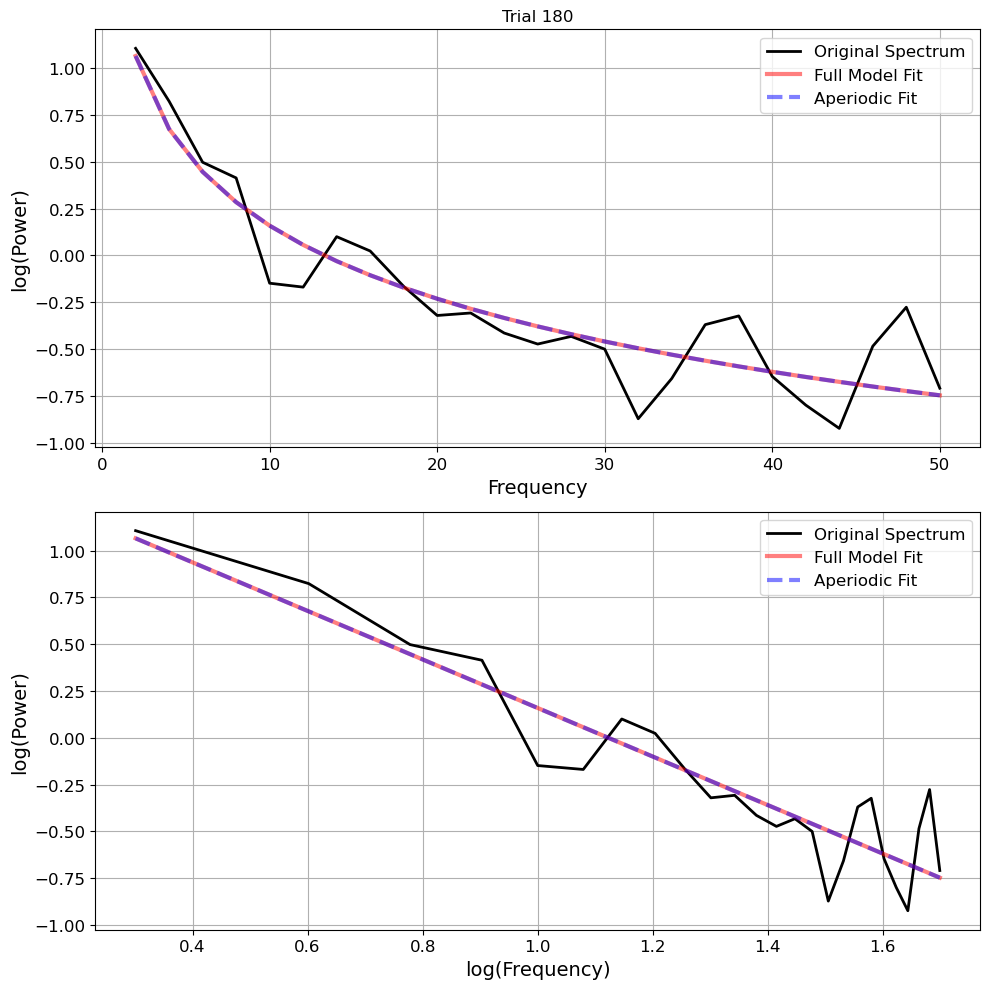

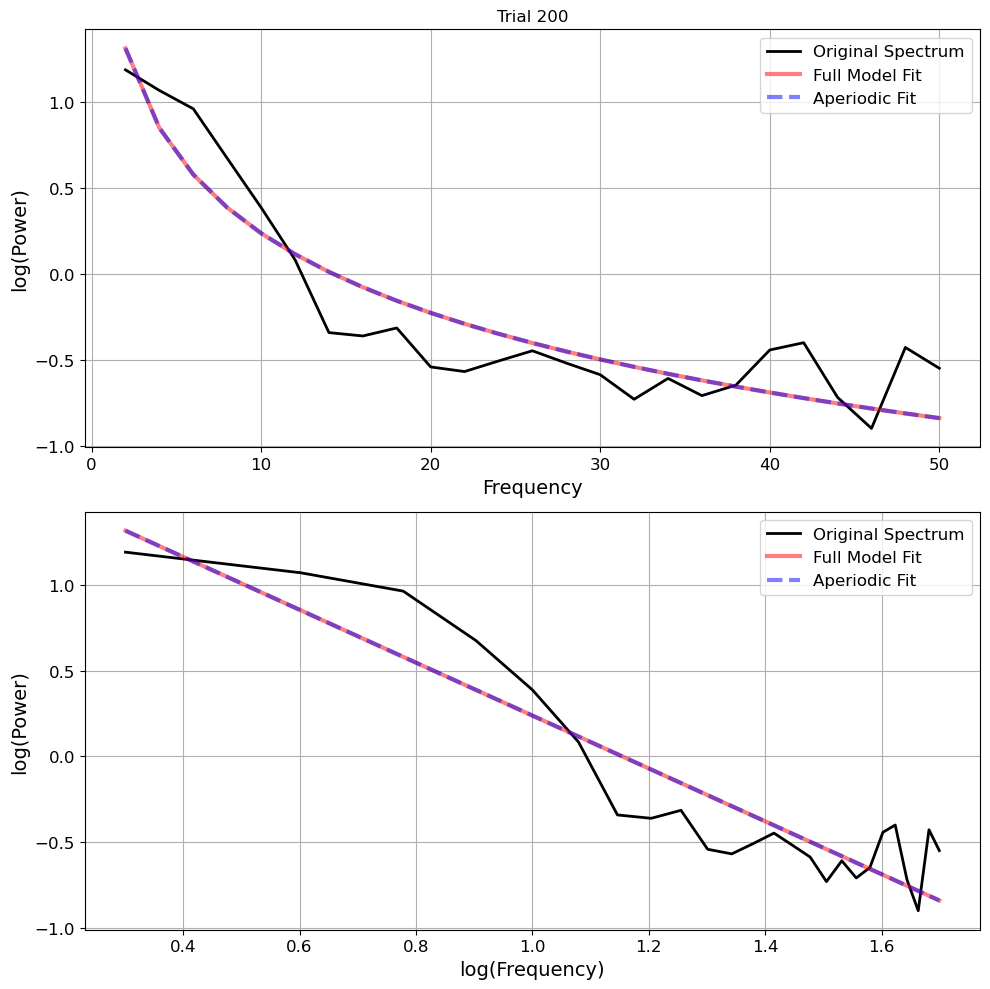

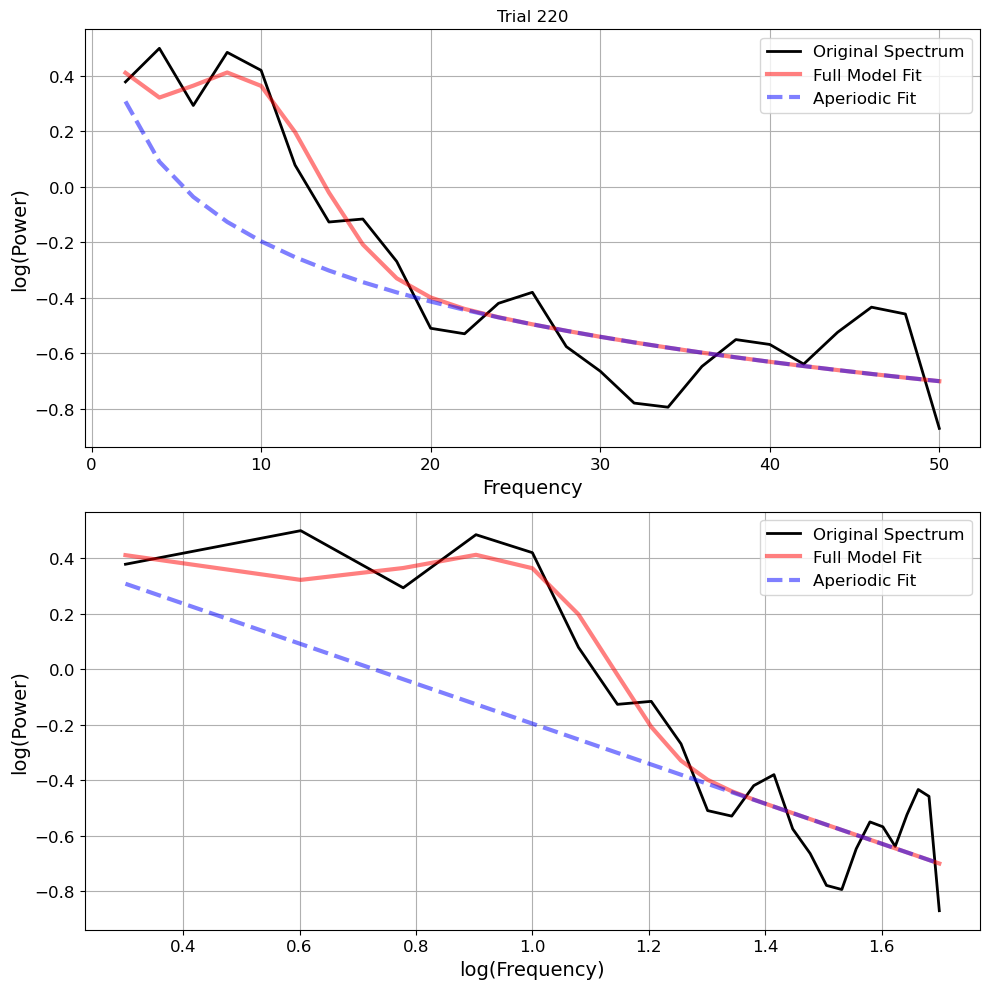

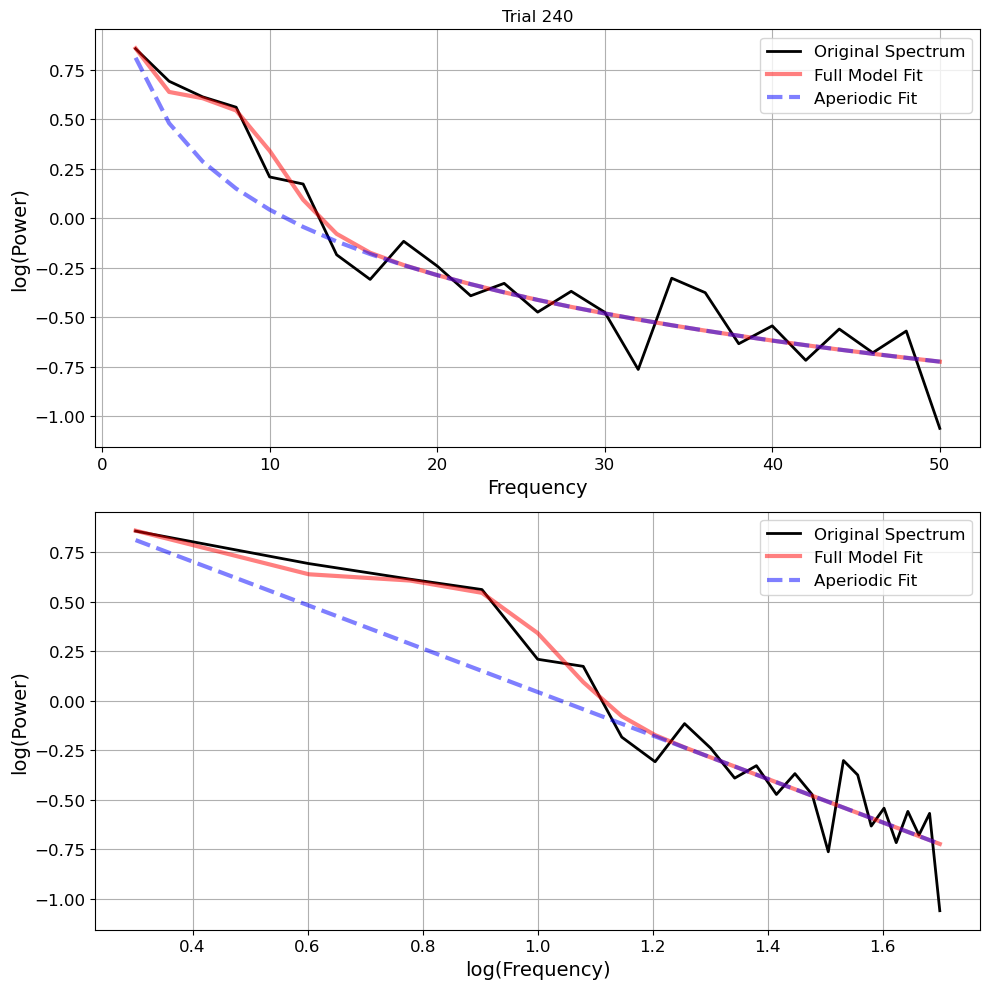

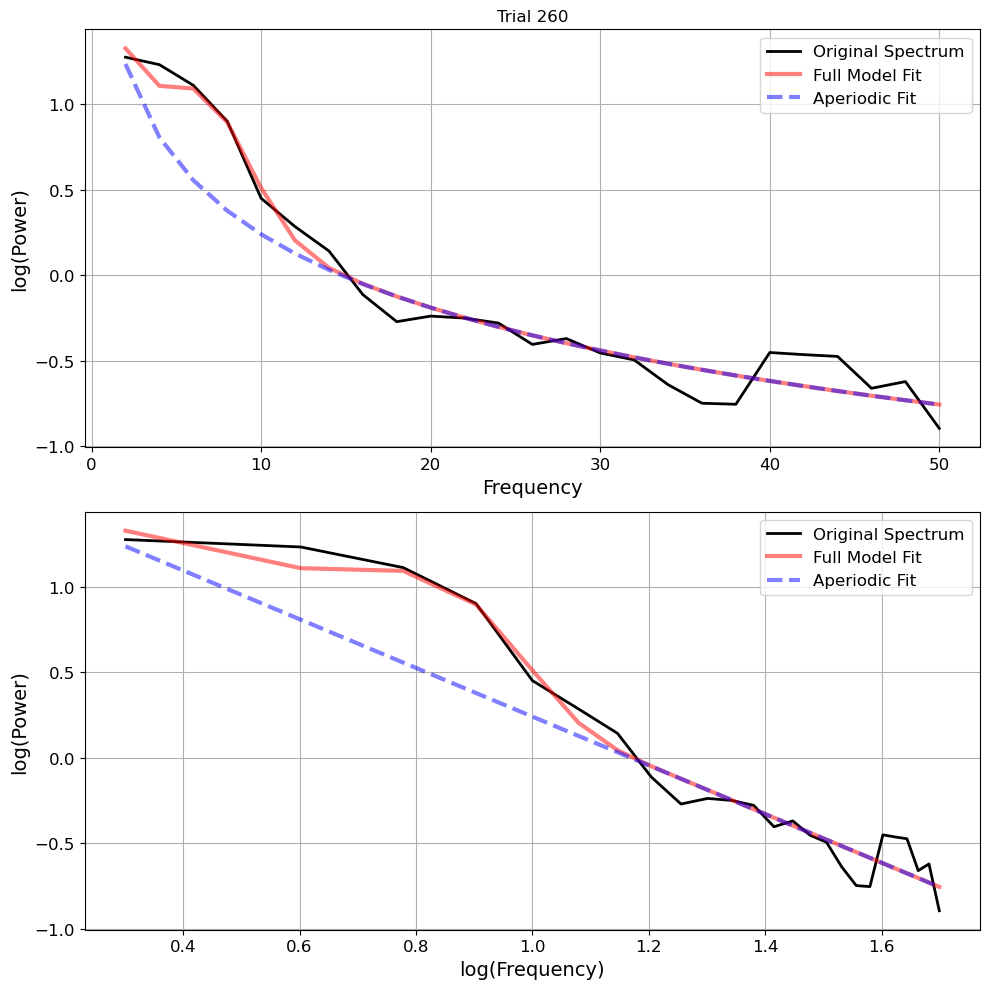

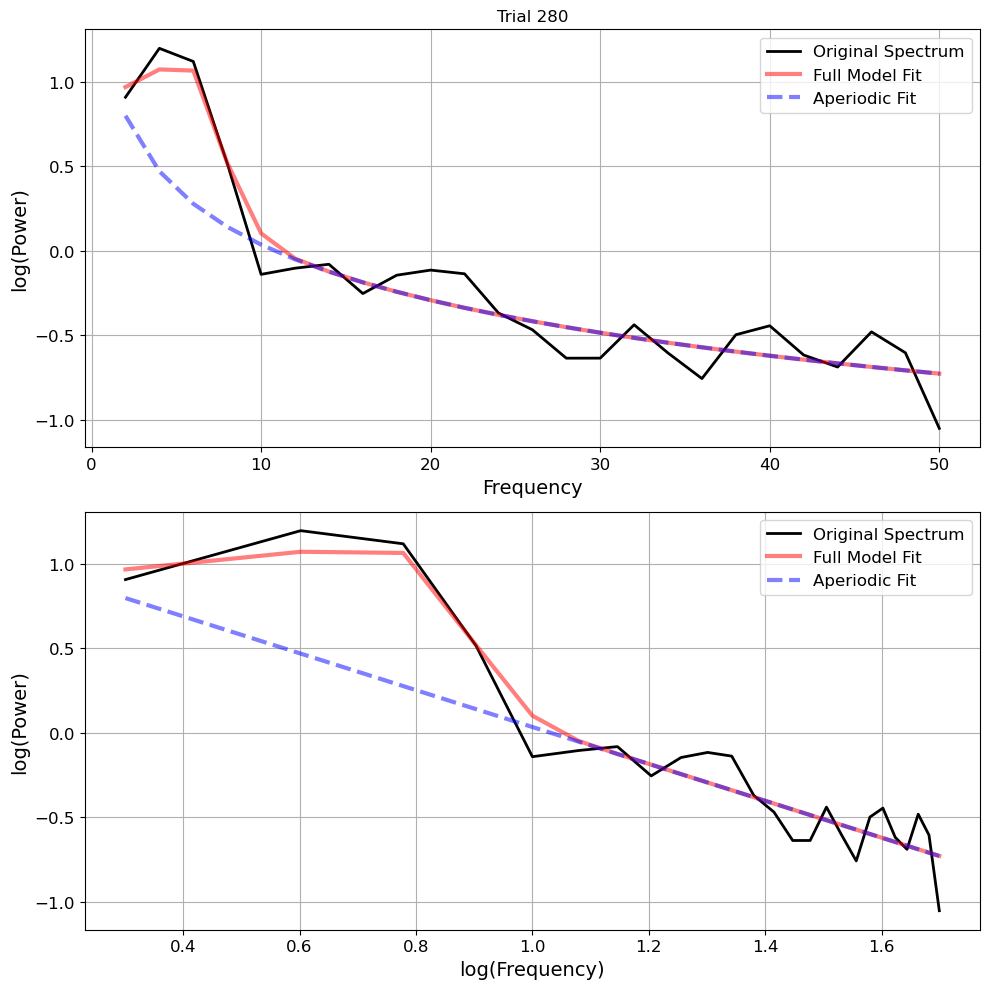

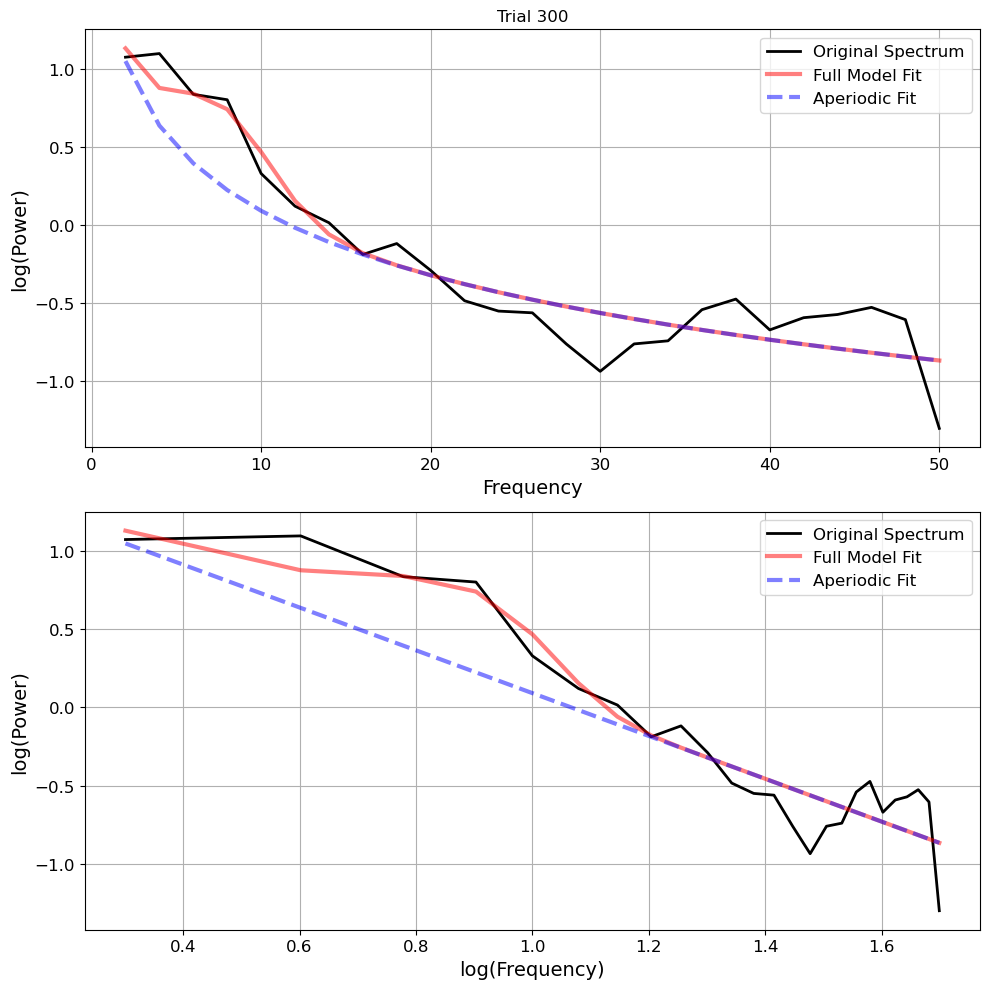

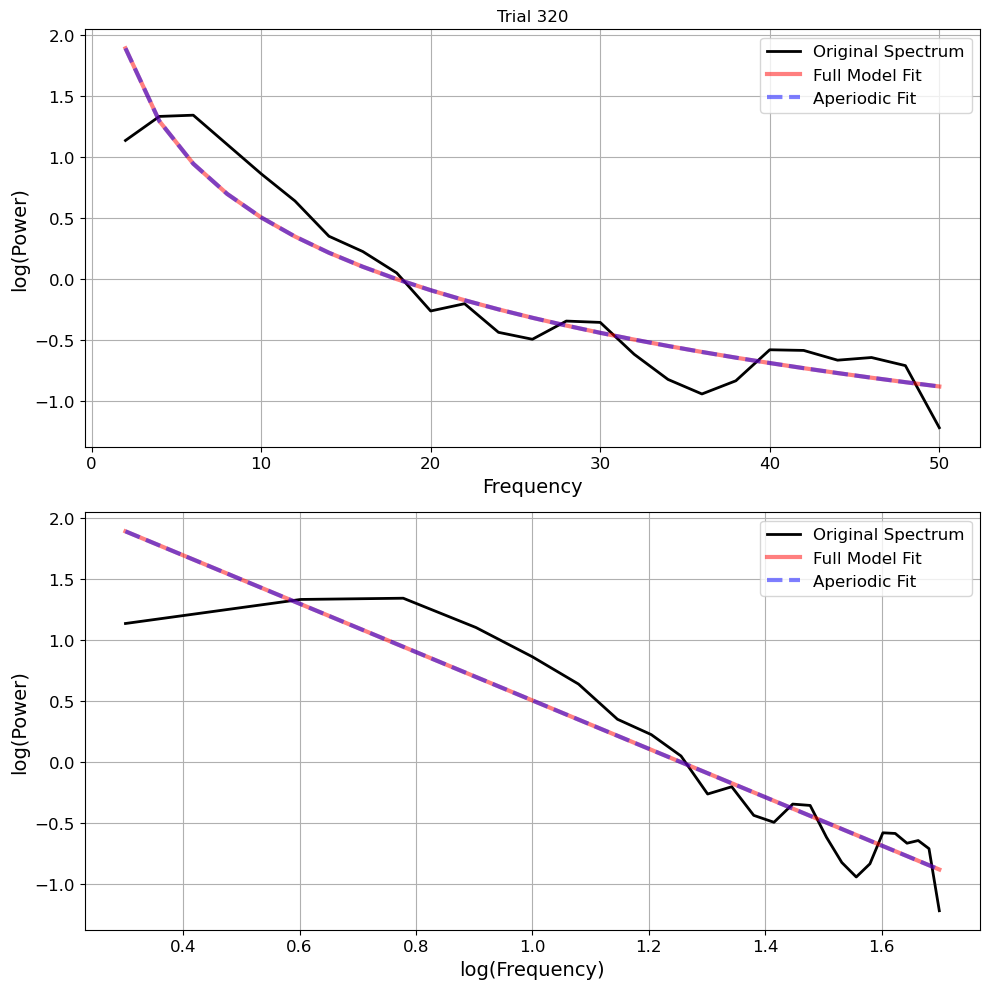

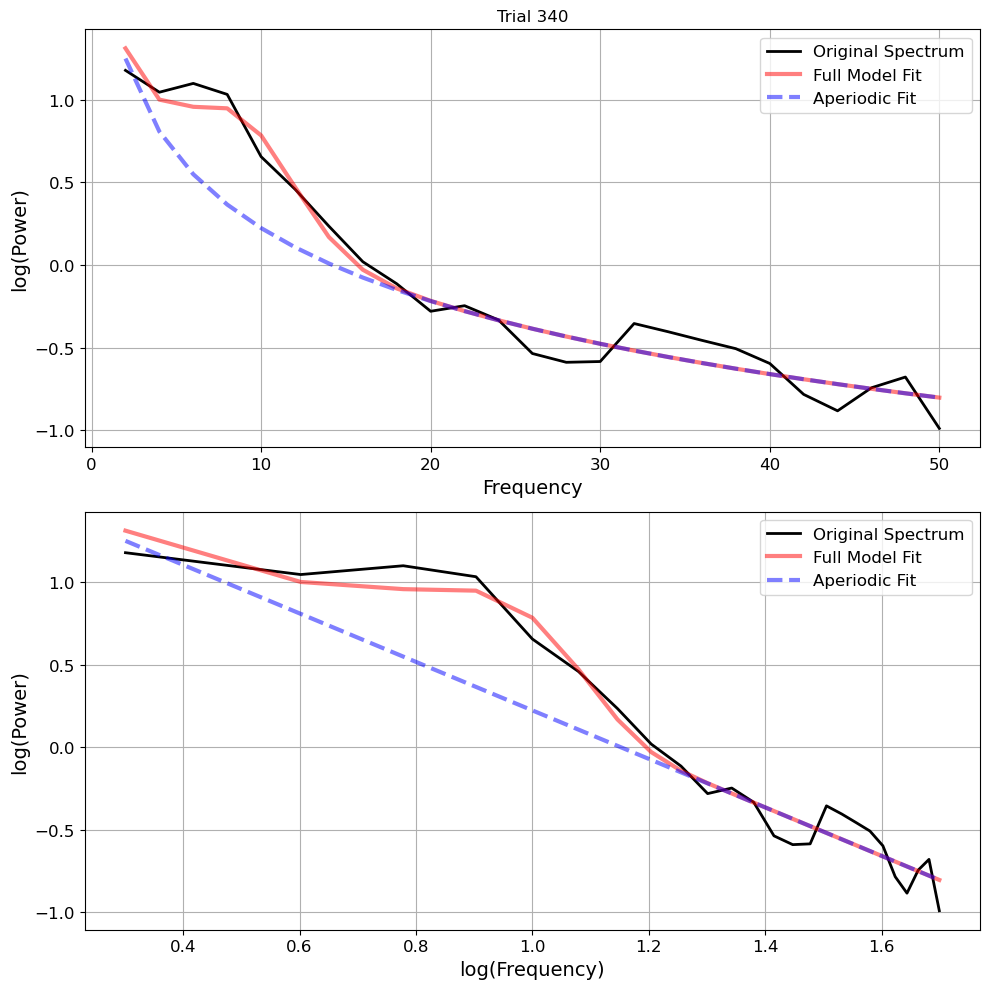

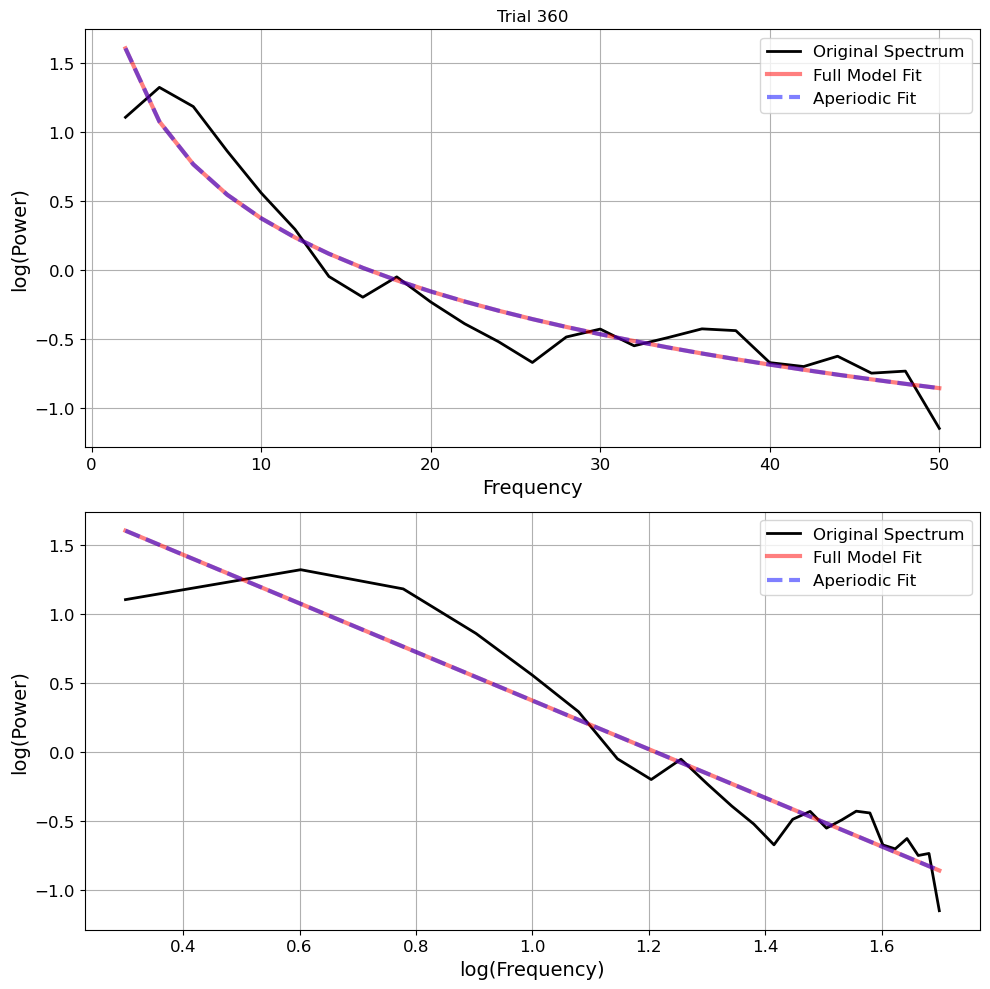

In [10]:
# Plot every 20th power spectrum
for i in range(0, len(pwr), 20):
    fm.fit(freqs, pwr[i], freq_range=fit_range)
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fm.plot(plt_log=False, ax=ax[0])
    fm.plot(plt_log=True, ax=ax[1])
    ax[0].set_title(f"Trial {i}")
    plt.show()

## Apply FOOOF Group to all trials

Fitting model across 364 power spectra.
Fitting model across 364 power spectra.
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 364                             
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                             

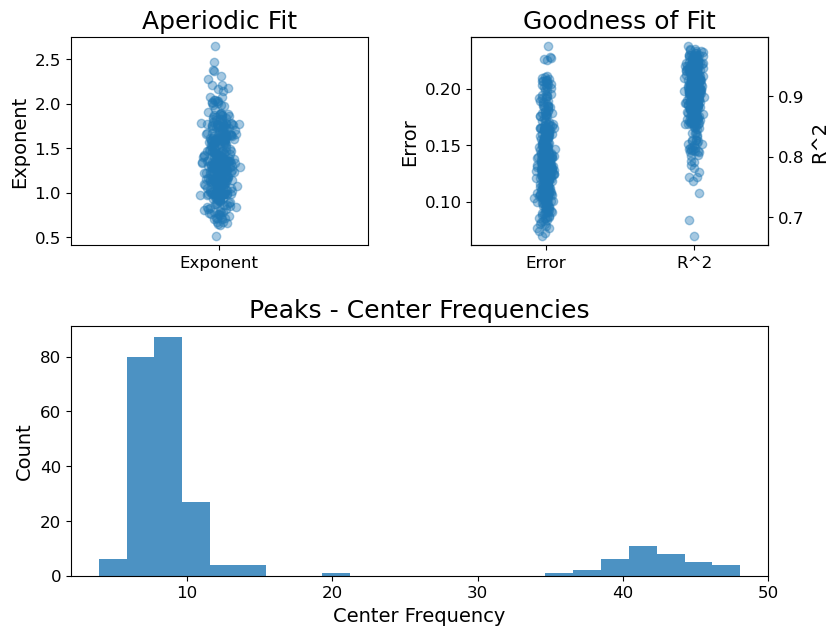

In [12]:
fg = SpectralGroupModel(**fooof_params)
fg.fit(freqs, pwr, freq_range=fit_range)
fg.report()

## Extract parameters

In [38]:
exps = fg.get_params('aperiodic_params', 'exponent')
offsets = fg.get_params('aperiodic_params', 'offset')
peaks = fg.get_params('peak_params')



In [40]:
offsets.shape

(364,)

In [42]:
peaks.shape

(246, 4)